# Analyze the run production (targets, compounds) of the sampling runs

# Some Setup
Define imports, some necessary variables, and some functions

## Imports

In [1]:
from collections import Counter
from matplotlib import rcParams
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
import pandas as pd
import pymongo

## Database definitions

In [2]:
# mongo_uri = open("../mongo_uri.csv").read().strip("\n")
client = pymongo.MongoClient()

db_names = [f"kms_YMDB_2ksampleC_T{i}" for i in [0, 3, 6]]

In [3]:
for db_name in client.list_databases():
    if db_name['name'].startswith("YMDB"):
        print(db_name['name'])
        # client.drop_database(db_name['name'])

## Function to analyze definitions

In [4]:
def get_found_dict(db, max_gens):
    targets = set("C" + i["_id"][1:] for i in client[db].target_compounds.find({}, {"_id": 1}))

    found_dicts = []
    for gen in range(1, max_gens+1):
        found_dict = dict()
        gen_compounds = set(i["_id"] for i in client[db].compounds.find({"Generation": {"$eq": gen}}, {"_id": 1}))
        found_targets = len(gen_compounds.intersection(targets))
        found_dict["targets"] = found_targets
        found_dict["generation"] = gen
        found_dict["run"] = db.replace(",", ".")
        found_dict["weight"] = db.split("_")[-1]

        found_dicts.append(found_dict)
        
    return found_dicts

## Manually input run info

In [5]:
# Manually retrieve total compounds generation
compound_gen_dict = {
    "kms_YMDB_2ksampleC_T0":
    {
        "0": 803,
        "1": 146091,
        "2": 314455,
        "3": 433681,
        "4": 511696,
        "5": 591036,
    },
    "kms_YMDB_2ksampleC_T3":
    {
        "0": 803,
        "1": 146091,
        "2": 339190,
        "3": 541788,
        "4": 670785,
        "5": 702338,
    },
    "kms_YMDB_2ksampleC_T6":
    {
        "0": 803,
        "1": 146091,
        "2": 364598,
        "3": 578476,
        "4": 639772,
        "5": 663111,
    },
   
}

---
---

# Process Data into dataframe

In [6]:
dict_list = []
n_gen = 5

# Grab data from MongoDB
for i, db in enumerate(db_names):
    dict_list.extend(get_found_dict(db, n_gen))

# Grab manually inserted data
for key, val in compound_gen_dict.items():
    for dict_entry in dict_list:
        if dict_entry["run"] == key:
            gen = dict_entry["generation"]

            dict_entry["compounds"] = val[str(gen)]

# Make df from the data
tani_df = pd.DataFrame(dict_list)
runs = [r for r in set(tani_df["run"])]

# Grab total values
for run in runs:
    run_total = {
        "run": run,
        "generation": "total",
        "targets": tani_df[tani_df["run"] == run]["targets"].sum(),
        "compounds": tani_df[tani_df["run"] == run]["compounds"].sum(),
        "weight": run.split("_")[-1],
    }
    tani_df = tani_df.append(run_total,  ignore_index=True)

# Grab melted DF
tani_melt_df = tani_df.melt(id_vars=["run", "generation", "weight"], value_vars=["targets", "compounds"], var_name="type", value_name="counts")

## Process Data

In [7]:
%%capture
compound_df = tani_melt_df[(tani_melt_df["type"] == "compounds") & (tani_melt_df["generation"] != "total")]
target_df = tani_melt_df[(tani_melt_df["type"] == "targets") & (tani_melt_df["generation"] != "total")]

w_dfs = []
weights = set(target_df.weight)
for weight in weights:
    w_dfs.append(target_df[target_df["weight"] == weight]["counts"].cumsum())

cumsum_df = pd.concat(w_dfs)
target_df.loc[cumsum_df.index, "cumsum"] = cumsum_df

total_targets = [{"generation": "Total Targets", "cumsum": 250, "weight": w} for w in weights]
target_df = target_df.append(total_targets)

In [8]:
cpd_trgt = compound_df.merge(target_df, on=["run", "generation"])
target_df["target_per_compound"] = cpd_trgt["counts_y"]/cpd_trgt["counts_x"]

target_df = target_df.fillna(0)
target_df.reset_index(drop=True, inplace=True)

w_dfs = []
weights = set(target_df.weight)
for weight in weights:
    w_dfs.append(target_df[target_df["weight"] == weight]["target_per_compound"].cumsum())

cumsum_df = pd.concat(w_dfs)
target_df.loc[cumsum_df.index, "target_per_compound_cumsum"] = cumsum_df

# Normalize to T0
target_df.loc[target_df.weight == "T0", "target_per_compound"] = target_df[target_df.weight == "T0"].target_per_compound / target_df[target_df.weight == "T0"].target_per_compound

# Load Fingerprint Data

In [9]:
T0_df = pd.read_csv("YMDB_2ksampleC_T0_similarity.csv")
T3_df = pd.read_csv("YMDB_2ksampleC_T3_similarity.csv")
T6_df = pd.read_csv("YMDB_2ksampleC_T6_similarity.csv")

# Figure Generation

In [10]:
from matplotlib import rcParams
params = {
   'axes.labelsize': 18,
   'font.size': 18,
   'legend.fontsize': 14,
   'legend.title_fontsize': 18,
   'xtick.labelsize': 18,
   'ytick.labelsize': 18,
   'text.usetex': False,
   'figure.figsize': [4.5, 4.5],
   }
rcParams.update(params)

# sns.set_palette("pastel")

<ipython-input-14-7b57aaf30b76>:89: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(["$T^0$", "$T^3$", "$T^6$"]) #, rotation=60, ha='right', rotation_mode="anchor")


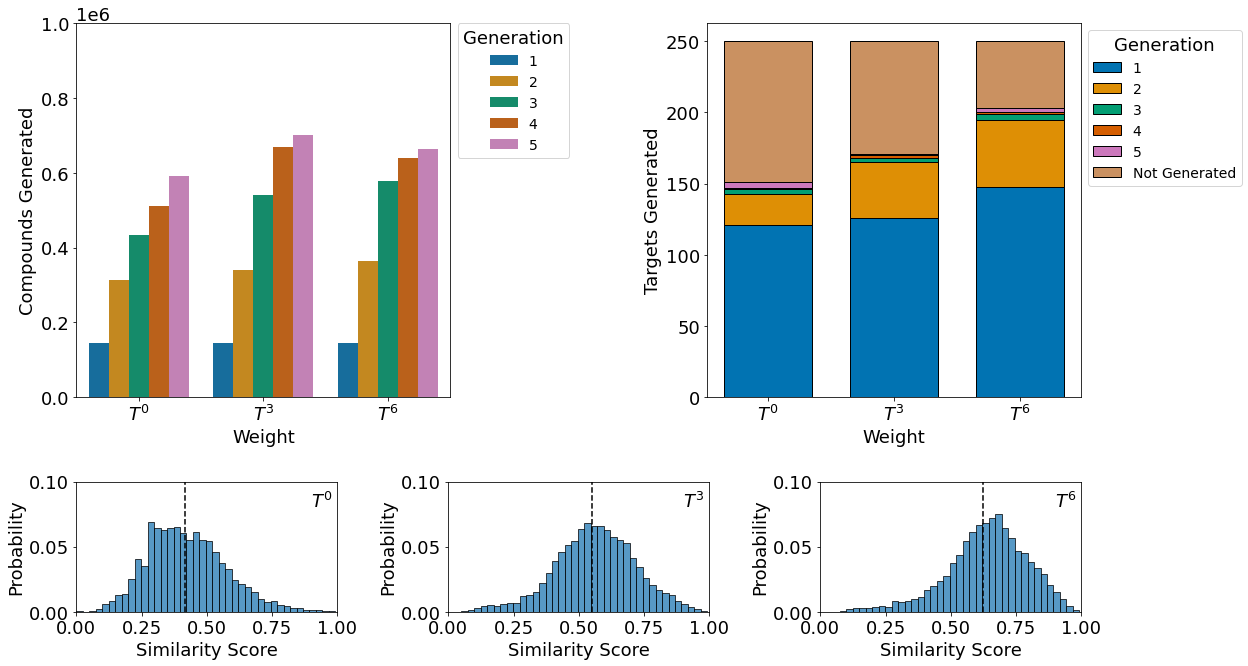

In [14]:
##########################################
# Base plot options
fig = plt.figure(figsize=(18, 11))
gs = fig.add_gridspec(3, 6)
axt1 = fig.add_subplot(gs[0:2, :3])
axt2 = fig.add_subplot(gs[0:2, 3:])
axb1 = fig.add_subplot(gs[-1, :2])
axb2 = fig.add_subplot(gs[-1, 2:4])
axb3 = fig.add_subplot(gs[-1, 4:])

taxs = [axt1, axt2]
baxs = [axb1, axb2, axb3]

##########################################
# Some Definitials up front
runs = list(set(compound_df.run))
runs = sorted(runs)

weights = list(set(compound_df.weight))
weights = sorted(weights)

palette = "colorblind"

cpd_legends = [str(i) for i in [1, 2, 3, 4, 5]]
target_legends = [str(i) for i in [1, 2, 3, 4, 5]] + ["Not Generated"]


##########################################
# Plot compound generation plot
ylim = (0, 1000000) 

ax = taxs[0]
sns.barplot(
    data=compound_df,
    x="weight", y="counts", hue="generation",
    ax=ax, #palette="dark", alpha=0.6
    palette=palette
)
ax.set(
    ylabel="Compounds Generated",
    xlabel="Weight",
    ylim=ylim
)

legend = ax.get_legend()
handles = legend.legendHandles

ax.legend(
    handles,
    cpd_legends,
    title="Generation"
    )

ax.ticklabel_format(axis='y', style='sci', scilimits=(6,6))
############################################################
ax = taxs[1]
g = sns.histplot(
    data=target_df,
    x="weight",
    hue="generation",
    weights="cumsum",
    palette=palette,
    alpha=1,
    shrink=0.7,
    ax=ax,
    # legend=True
)

ax.set(
    xlabel="Weight",
    ylabel="Targets Generated"
);
# ax.set_xlim(-0.5, 4);

legend = ax.get_legend()
handles = legend.legendHandles

ax.legend(
    handles,
    target_legends,
    bbox_to_anchor=(1,1),
    loc="upper left",
    title="Generation"
    )

taxs[0].legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0, title="Generation")

for ax in taxs:
    ax.set_xticklabels(["$T^0$", "$T^3$", "$T^6$"]) #, rotation=60, ha='right', rotation_mode="anchor")
    ax.set_xlabel("Weight")
    ax.set_aspect(1./ax.get_data_ratio())

############################################################
## Bottom
bins = 40

dfs = [T0_df, T3_df, T6_df]
for i in range(0, 3):
    df = dfs[i]
    ax = baxs[i]
    sns.histplot(x="max_similarity",
        data = df[
            (~df.SMILES.map(lambda s: s.startswith("CC(C)(COP(=O)(O)OP(=O)(O)OC[C@H]1O[C@@") or s.startswith("C=C(C)C(=CSCCNC(=O)CCNC(=O)[C@H](O)C(C")))
            & (df.max_similarity != 1)
            & ((df.max_similarity < 0.26) | (df.max_similarity > 0.27))
            ],
            ax=ax, bins=bins, stat="probability")

    ax.vlines(df.max_similarity.mean(), 0, 20000, linestyles='--', color='k')
    ax.set(
        xlim=(0, 1),
        ylim=(0, 0.1),
        xlabel="Similarity Score"
    )
    ax.set_aspect(1/2/ax.get_data_ratio())
    ax.text(0.9, 0.08, f"$T^{(i-1)*3 + 3}$", fontsize=18)  

fig.subplots_adjust(hspace=0.5)
fig.subplots_adjust(wspace=1.5)

taxs[0].set_anchor("W")
taxs[1].set_anchor("E")
baxs[0].set_anchor("W")
baxs[1].set_anchor("C")
baxs[2].set_anchor("E")

fig.savefig("../figures/fig5_tanimoto_sampling.png", dpi='figure', bbox_inches='tight')